In [1]:
#!pip install torchsummary --quiet

# 1. About the dataset
This dataset was downloaded from NEU Metal Surface Defects Databse which contains six kinds of typical surface defects of the hot-rolled steel strip are collected, i.e., rolled-in scale (RS), patches (Pa), crazing (Cr), pitted surface (PS), inclusion (In) and scratches (Sc). The database includes 1,800 grayscale images: 300 samples each of six different kinds of typical surface defects. The detailed defects are as follows:

* **Inclusion**: Inclusion is a typical defect of metal surface defects. Some inclusions are loose and easy to fall off, some pressed into the plate.<br>
* **Crazing**: Crazing is the phenomenon that produces some cracks on the surface of a material.
* **Patches**: A part of metal marked out from the rest by a particular characteristic.
* **Pitted surface**: Pitting is a form of corrosion that focuses on a very small range of metal surfaces and penetrates into the metal interior. Pitting is generally small in diameter but deep in depth.
* **Scratches**: A scratch is a mark of abrasion on a surface.
* **Rolled in scale**: A rolled-in scale defect occurs when the mill scale is rolled into the metal duringthe rolling process.<br>
The dataset divided into 3 directories. The training directory contains 276 images of each class from the 300 images. The rest 24 images of each class also divided into tests and valid datasets.

# 2. Importing the required libraries

In [2]:
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from PIL import Image

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import models

import warnings
warnings.filterwarnings("ignore")

# 3. Loading the data from dataset

In [3]:
train_dir = "./NEU Metal Surface Defects Data/train"
test_dir = "./NEU Metal Surface Defects Data/test"
valid_dir = "./NEU Metal Surface Defects Data/valid"

print("Path Directory: ", os.listdir("./NEU Metal Surface Defects Data"))
print("Train Directory:",os.listdir(train_dir))
print("valid Direcory: ", os.listdir(valid_dir))
print("Test Directory: ", os.listdir(test_dir))

CLASS_NAMES = os.listdir(train_dir)

Path Directory:  ['Thumbs.db', 'test', 'train', 'valid']
Train Directory: ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']
valid Direcory:  ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']
Test Directory:  ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']


In [4]:
print("Training Inclusion data:",len(os.listdir(train_dir+'/'+'Inclusion')))
print("Testing Inclusion data:",len(os.listdir(test_dir+'/'+'Inclusion')))
print("Validation Inclusion data:",len(os.listdir(valid_dir+'/'+'Inclusion')))

Training Inclusion data: 276
Testing Inclusion data: 12
Validation Inclusion data: 12


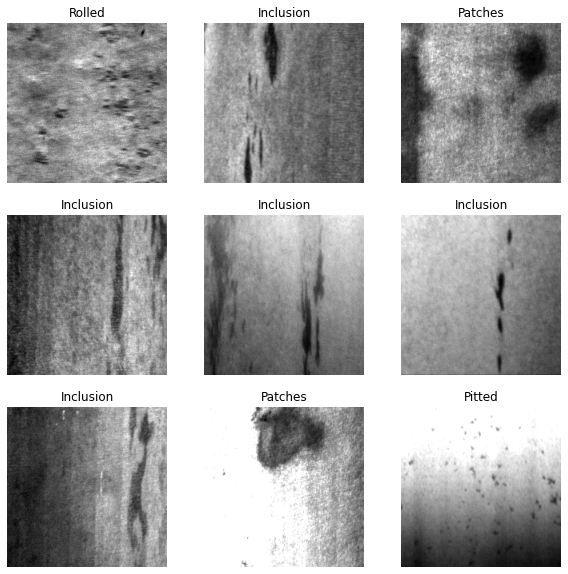

In [5]:
# Function to show random images from training dataset

def show_random_images(data_dir, num_images):
    class_names = os.listdir(data_dir)
    num_rows = int(num_images ** 0.5)
    num_cols = int(num_images ** 0.5)
    fig, axarr = plt.subplots(num_rows, num_cols, figsize=(10,10))
    for i in range(num_rows):
        for j in range(num_cols):
            class_num = random.randint(0, len(class_names)-1)
            img_name = random.choice(os.listdir(os.path.join(data_dir, class_names[class_num])))
            img_path = os.path.join(data_dir, class_names[class_num], img_name)
            img = mpimg.imread(img_path)
            axarr[i, j].imshow(img, cmap = 'gray')
            axarr[i, j].set_title(class_names[class_num])
            axarr[i, j].axis('off')
            
    plt.show()

show_random_images(train_dir, 9)

# 4. Image Preprocessing
This is the most important step of working with image data. During image preprocessing, we simultaneously prepare the images for our network and apply **Data Augmentation** to the training set. The idea of data augmentation is to artificially increase the number of training images our model sees by applying random transformations to the images. For example, we can randomly rotate or crop the images or flip them horizontally.
<center><h2>Data Augumentation</h2></center>
<img style="display: block; margin: auto; width: 70%; height: 70%;" src="https://149695847.v2.pressablecdn.com/wp-content/uploads/2020/08/UKwFg.jpg">

In [6]:
image_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        
    ]),
    
    'valid': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

In [7]:
data = {
    'train': datasets.ImageFolder(root=train_dir, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_dir, transform=image_transforms['valid'])
}

print("Training data: ", len(data['train']))
print("Validation data: ", len(data['valid']))

Training data:  1656
Validation data:  72


In [8]:
BATCH_SIZE = 32
NUM_CLASSES = 6

train_loader = DataLoader(data['train'], batch_size = BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(data['valid'], batch_size = BATCH_SIZE, shuffle=True)

# 5. Loading pretrainded model
Transfer learning is about leveraging feature representations from a pre-trained model, so you don’t have to train a new model from scratch.

The pre-trained models are usually trained on massive datasets that are a standard benchmark in the computer vision frontier. The weights obtained from the models can be reused in other computer vision tasks.

These models can be used directly in making predictions on new tasks or integrated into the process of training a new model. Including the pre-trained models in a new model leads to lower training time and lower generalization error.

Transfer learning is particularly very useful when you have a small training dataset. In this case, you can, for example, use the weights from the pre-trained models to initialize the weights of the new model.

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
# Loading Pretrained Weights of Resnet50
model = models.resnet50(pretrained = True).to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

# 6. Building and Training Model

In [11]:
# Freeze all layers except the last one
for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(64, NUM_CLASSES)
)

# Transfer the model to device
model = model.to(device)

### 6.1 Define loss function and optimizer

In [12]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

### 6.2 Training loop

In [13]:
num_epochs = 20
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    train_loss = 0
    valid_loss = 0

    # Training loop
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
    
        # Validation loop
    model.eval()
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        valid_loss += loss.item() * images.size(0)
        valid_loss /= len(valid_loader.dataset)
        valid_losses.append(valid_loss)
    
    # Print training and validation loss
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')


Epoch [1/20], Train Loss: 0.0261, Valid Loss: 0.2111
Epoch [2/20], Train Loss: 0.0256, Valid Loss: 0.2078
Epoch [3/20], Train Loss: 0.0256, Valid Loss: 0.2063
Epoch [4/20], Train Loss: 0.0257, Valid Loss: 0.2026
Epoch [5/20], Train Loss: 0.0253, Valid Loss: 0.1963
Epoch [6/20], Train Loss: 0.0241, Valid Loss: 0.1925
Epoch [7/20], Train Loss: 0.0234, Valid Loss: 0.1751
Epoch [8/20], Train Loss: 0.0213, Valid Loss: 0.1518
Epoch [9/20], Train Loss: 0.0207, Valid Loss: 0.1366
Epoch [10/20], Train Loss: 0.0157, Valid Loss: 0.1242
Epoch [11/20], Train Loss: 0.0159, Valid Loss: 0.1042
Epoch [12/20], Train Loss: 0.0170, Valid Loss: 0.0891
Epoch [13/20], Train Loss: 0.0137, Valid Loss: 0.0882
Epoch [14/20], Train Loss: 0.0147, Valid Loss: 0.0693
Epoch [15/20], Train Loss: 0.0158, Valid Loss: 0.0501
Epoch [16/20], Train Loss: 0.0104, Valid Loss: 0.0623
Epoch [17/20], Train Loss: 0.0097, Valid Loss: 0.0470
Epoch [18/20], Train Loss: 0.0132, Valid Loss: 0.0489
Epoch [19/20], Train Loss: 0.0089, Va

# 7. Test the model on test dataset

In [14]:
test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_data = datasets.ImageFolder(test_dir, transform=test_transforms)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)


model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the test images: 88.88888888888889 %


### 7.1 Plot confusion matrix

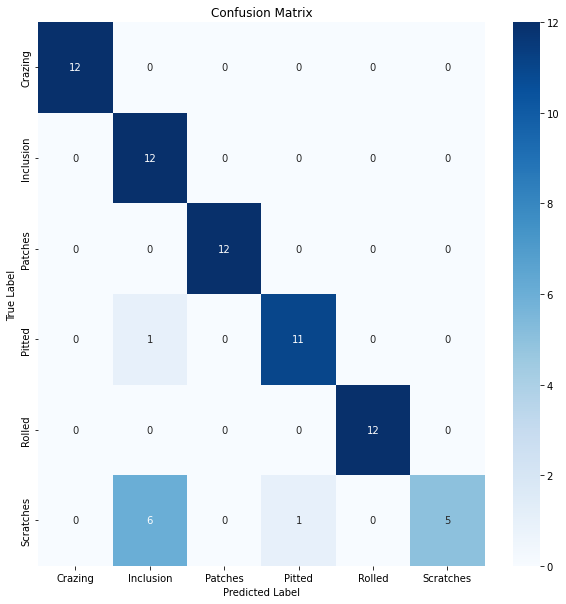

              precision    recall  f1-score   support

     Crazing       1.00      1.00      1.00        12
   Inclusion       0.63      1.00      0.77        12
     Patches       1.00      1.00      1.00        12
      Pitted       0.92      0.92      0.92        12
      Rolled       1.00      1.00      1.00        12
   Scratches       1.00      0.42      0.59        12

    accuracy                           0.89        72
   macro avg       0.92      0.89      0.88        72
weighted avg       0.92      0.89      0.88        72



In [15]:
    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))